# Sentiment

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
df_train = pd.read_csv('/content/drive/My Drive/PENDADARAN/49000_DATA_NEWEST_.csv')

Class 0: 36927
Class 1: 6042


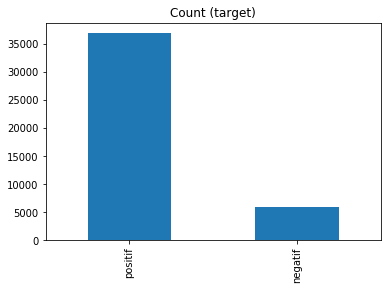

In [58]:
target_count_sent = df_train.labeled_Stop_Neg.value_counts()
print('Class 0:', target_count_sent["positif"])
print('Class 1:', target_count_sent["negatif"])

target_count_sent.plot(kind='bar', title='Count (target)');

In [0]:
#  net             pos            neg
count_class_0_sent, count_class_1_sent = df_train.labeled_Stop_Neg.value_counts()

# Divide by class
df_class_0_sent = df_train[df_train['labeled_Stop_Neg'] == "positif"]
df_class_1_sent = df_train[df_train['labeled_Stop_Neg'] == "negatif"]

Random over-sampling:
positif    36927
negatif    36927
Name: labeled_Stop_Neg, dtype: int64


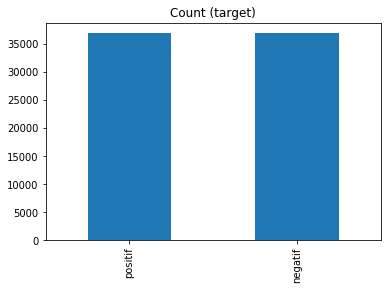

In [60]:
df_class_1_over_sent = df_class_1_sent.sample(count_class_0_sent, replace=True)
df_test_over_sent = pd.concat([df_class_0_sent, df_class_1_over_sent], axis=0)

print('Random over-sampling:')
print(df_test_over_sent.labeled_Stop_Neg.value_counts())

df_test_over_sent.labeled_Stop_Neg.value_counts().plot(kind='bar', title='Count (target)');

In [0]:
# to be imported
from __future__ import print_function
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer

from keras.models import load_model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM, GRU
from keras.callbacks import EarlyStopping
from keras import initializers
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [0]:
cols_sent = ['labeled_Stop_Neg','Review_Stopwords_Joined']
d_sent = df_test_over_sent[cols_sent]
d_sent = d_sent[d_sent['Review_Stopwords_Joined'].notnull()]

d_sent = d_sent[d_sent['labeled_Stop_Neg'].notnull()]

In [64]:
d_sent.reset_index(drop=True,inplace=True)
x_sent = d_sent.iloc[:, 1].values
y_sent = d_sent.iloc[:, 0].values
print(np.unique(y_sent, return_counts=True))

(array(['negatif', 'positif'], dtype=object), array([36927, 36927]))


In [65]:
len(d_sent)

73854

In [0]:
d_sent.replace('', np.nan, inplace=True)
d_sent.dropna(inplace=True)
d_sent.reset_index(drop=True,inplace=True)
x_sent = d_sent.iloc[:, 1].values
y_sent = d_sent.iloc[:, 0].values

In [67]:
len(y_sent)

73854

In [0]:
tk_sent = Tokenizer()

In [69]:
text_sent = d_sent['Review_Stopwords_Joined'].values
maxlen_sent = max([len(i.split()) for i in text_sent])
tk_sent.fit_on_texts(text_sent) # each word in text is given a unique integer number
x_sent = tk_sent.texts_to_sequences(x_sent) # represent a completely new set of word sequence
x_sent = sequence.pad_sequences(x_sent, maxlen_sent) # to ensure that all sequences in a list have the same length
vocab_sent = max([len(tk_sent.word_index)]) + 1
print(x_sent)

[[   0    0    0 ...   37 1182  294]
 [   0    0    0 ...   94 9675 9676]
 [   0    0    0 ...  814  162  851]
 ...
 [   0    0    0 ...  209 4587 4588]
 [   0    0    0 ...   60   10  120]
 [   0    0    0 ...  733 1721 1521]]


In [70]:
print("vocab sentiment : " + str(vocab_sent))
print("maxlen sentiment : " + str(maxlen_sent))

vocab sentiment : 17631
maxlen sentiment : 27


In [71]:
from sklearn.preprocessing import LabelEncoder
# encoding the levels of categorical features into numeric values
labelencoder_Y_sent = LabelEncoder()
y_sent = labelencoder_Y_sent.fit_transform(y_sent)
print(y_sent)
print(np.unique(y_sent, return_counts=True))

[1 1 1 ... 0 0 0]
(array([0, 1]), array([36927, 36927]))


In [72]:
from tensorflow.keras import utils as np_utils
y_sent = np_utils.to_categorical(y_sent, num_classes= 2)
# One hot encoded
print(y_sent)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [74]:
test_split = 0.33
from sklearn.model_selection import train_test_split
x_train_sent, x_test_sent, y_train_sent, y_test_sent, indices_train_sent, indices_test_sent = train_test_split(x_sent, y_sent, d_sent.index, test_size=0.33, random_state=42)

print(x_train_sent.shape)
print(y_train_sent.shape)
print(x_test_sent.shape)
print(y_test_sent.shape)
print(y_sent)

(49482, 27)
(49482, 2)
(24372, 27)
(24372, 2)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [75]:
x_train_sent = sequence.pad_sequences(x_train_sent, maxlen=maxlen_sent)
x_test_sent = sequence.pad_sequences(x_test_sent, maxlen=maxlen_sent)
print('x_train_sent shape:', x_train_sent.shape)
print('x_test_sent shape:', x_test_sent.shape)

x_train_sent shape: (49482, 27)
x_test_sent shape: (24372, 27)


In [0]:
embedding_dims = 64
filters = 200
kernel_size = 9
hidden_dims = 128
dropout = 0.25
lstm_unit = 64
gru_unit = 64

In [77]:
model_sent = Sequential()

model_sent.add(Embedding(vocab_sent,
               embedding_dims,
               input_length=maxlen_sent))
model_sent.add(Dropout(dropout))
model_sent.add(Conv1D(filters,
               kernel_size,
               padding='valid',
               activation='relu',
               strides=1))
model_sent.add(GlobalMaxPooling1D())
    
model_sent.add(Dense(hidden_dims))
model_sent.add(Dropout(dropout))
model_sent.add(Activation('relu'))
    
model_sent.add(Dense(2))
model_sent.add(Activation('sigmoid'))
    
model_sent.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])    

history_sent = model_sent.fit(x_train_sent, y_train_sent,
          batch_size=64,
          epochs=80,
          validation_split = 0.33,
          callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001)])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 33152 samples, validate on 16330 samples
Epoch 1/80





33152/33152 [==============================] - 21s 643us/step - loss: 0.3186 - acc: 0.8565 - val_loss: 0.1885 - val_acc: 0.9321
Epoch 2/80
33152/33152 [==============================] - 20s 612us/step - loss: 0.1230 - acc: 0.9572 - val_loss: 0.1563 - val_acc: 0.9444
Epoch 3/80
33152/33152 [==============================] - 20s 612us/step - loss: 0.0639 - acc: 0.9783 - val_loss: 0.1644 - val_acc: 0.9508
Epoch 4/80
33152/33152 [==============================] - 20s 612us/step - loss: 0.0411 - acc: 0.9868 - val_loss: 0.1460 - val_acc: 0.9577
Epoch 5/80
33152/33152 [==============================] - 21s 626us/step - loss: 0.0287 - acc: 0.9909 - val_loss: 0.1550 - val_acc: 0.9572
Epoch 6/80
33152/33152 [========

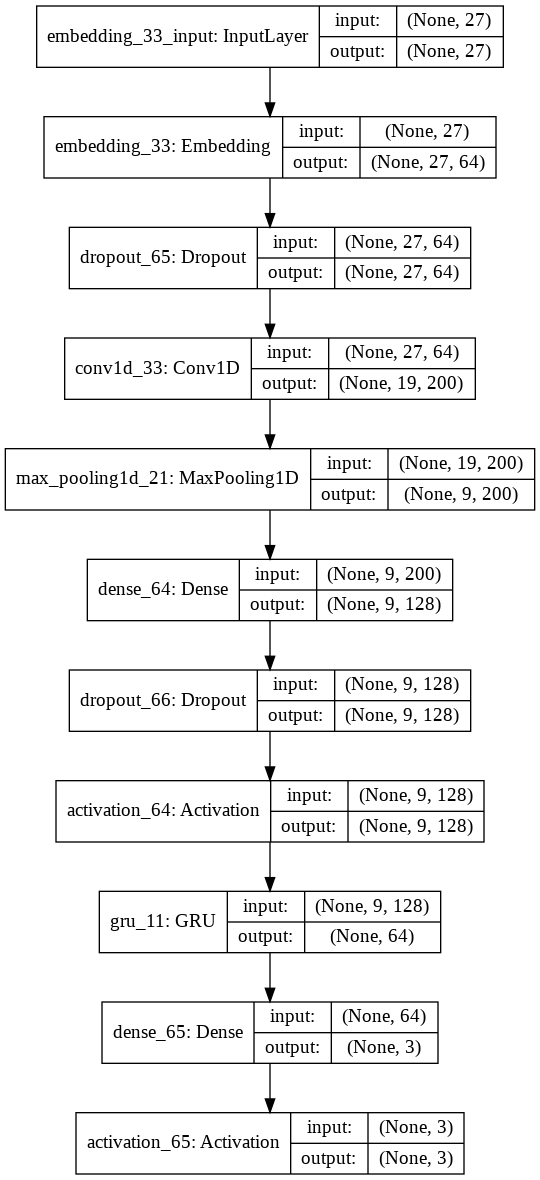

In [0]:
from keras.utils.vis_utils import plot_model

model = Sequential()
model.add(Embedding(vocab_sent,
                    embedding_dims,
                    input_length=maxlen_sent))
model.add(Dropout(dropout))
model.add(Conv1D(filters,
                    kernel_size,
                    padding='valid',
                    activation='relu',
                    strides=1))
model.add(MaxPooling1D())
model.add(Dense(hidden_dims)) # ini
model.add(Dropout(dropout))
model.add(Activation('relu'))

model.add(GRU(gru_unit)) 
    
model.add(Dense(3))
model.add(Activation('softmax'))

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Evaluate Sentiment

In [0]:
new_review_category_sent = model_sent.predict_classes(x_test_sent)

In [0]:
decode_sent = np.argmax(y_test_sent, axis=1)

In [0]:
lab_sent = ["negatif","positif"]

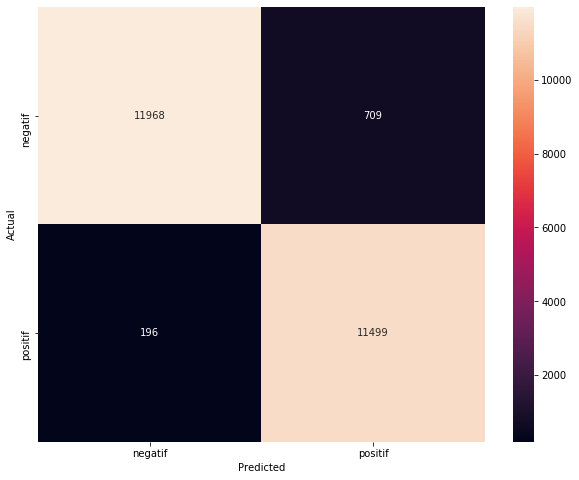

In [84]:
from sklearn.metrics import confusion_matrix
def conf_matrix(Y_act, Y_pred, lab):
    confusion_mtx = confusion_matrix(Y_act, Y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_mtx, annot=True, fmt="d", xticklabels=lab, yticklabels=lab)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

conf_matrix(new_review_category_sent, decode_sent, lab_sent)

In [85]:
from sklearn.metrics import accuracy_score
accuracy_score(new_review_category_sent, decode_sent)

0.9628672246840637

In [86]:
from sklearn.metrics import accuracy_score
accuracy_score(new_review_category_sent, decode_sent)

0.9628672246840637

In [87]:
from sklearn.metrics import classification_report
print(classification_report(new_review_category_sent, decode_sent))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     12677
           1       0.94      0.98      0.96     11695

    accuracy                           0.96     24372
   macro avg       0.96      0.96      0.96     24372
weighted avg       0.96      0.96      0.96     24372



In [88]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

print('Accuracy:', accuracy_score(new_review_category_sent, decode_sent))
print('F1 score:', f1_score(new_review_category_sent, decode_sent, average='macro'))
print('Recall:', recall_score(new_review_category_sent, decode_sent, average='macro'))
print('Precision:', precision_score(new_review_category_sent, decode_sent, average='macro'))

Accuracy: 0.9628672246840637
F1 score: 0.9628534690184862
Recall: 0.9636563212326876
Precision: 0.9629051041403139


In [89]:
accr_sent = model_sent.evaluate(x_test_sent,y_test_sent)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_sent[0],accr_sent[1]))

24372/24372 [==============================] - 3s 106us/step
Test set
  Loss: 0.183
  Accuracy: 0.963


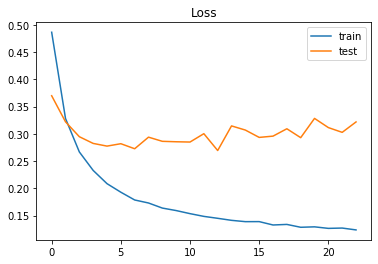

In [0]:
plt.title('Loss')
plt.plot(history_sent.history['loss'], label='train')
plt.plot(history_sent.history['val_loss'], label='test')
plt.legend()
plt.show();

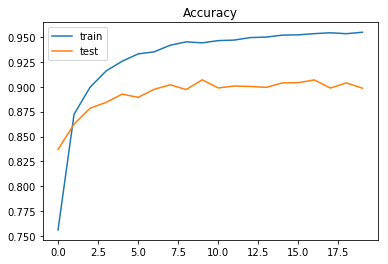

In [0]:
plt.title('Accuracy')
plt.plot(history_sent.history['acc'], label='train')
plt.plot(history_sent.history['val_acc'], label='test')
plt.legend()
plt.show();